# Simplified ReLearn Model Implementation

This notebook demonstrates a simplified version of the ReLearn model from the paper "Relation Learning on Social Networks with Multi-Modal Graph Edge Variational Autoencoders".

Key elements:
- Gaussian Mixture Variational Autoencoder for edge embeddings
- Two decoders: network proximity and node attributes
- No information diffusion decoder (omitted from the original model)

In [1]:
# Import necessary libraries
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Import our RGG weighted graph generator
from utils.graphs.rgg import *
from utils.visuals import plot_matrices

def euclidean_sampler(n, d=10):
    return np.random.beta(2,5, [n, d])
    return np.random.uniform(0, 1, size=(n, d))

rgg_weighted = LatentSpaceRGG(
    latent_sampler=euclidean_sampler,
    distance_fn=euclidean_distance,
    connection_rule="radius",
    threshold=0.8,
    weight_fn=lambda d: 1 / (d + 1e-5)  # Avoid division by zero
)

# Import our ReLearn model implementation
from relearn.model import ReLearnModel, run_relearn_pipeline

/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:128: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_NSt3__18optionalINS6_17basic_string_viewIcNS6_11char_traitsIcEEEEEE
  Referenced from: <2BF76774-0954-3F15-B7FE-8A5E5111D7DF> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <A51C8C05-245A-3989-8D3C-9A6704422CA5> /Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/Users/aldric-l/Library/Python/3.11/lib/python/site-packages/torch_geometric/typing.py:166: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/

## 1. Generate Graph

We use the provided RGG (Random Geometric Graph) generator to create a weighted graph with 500 nodes and their 2D latent positions.

In [2]:
# Generate graph with 500 nodes
graph, latent = rgg_weighted.generate_graph(n=500)

print(f"Graph generated with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges")
print(f"Latent positions shape: {latent.shape}")

Graph generated with 500 nodes and 95773 edges
Latent positions shape: (500, 10)


## 2. Model Configuration

Define hyperparameters for the ReLearn model:

In [3]:
# Model hyperparameters
hidden_dim = 128       # Hidden dimension for GCN and MLPs
z_dim = 32           # Dimension of edge embeddings
num_mixtures = 3     # Number of Gaussian mixtures
num_epochs = 300     # Training epochs

# Weighting parameters for loss components
lambda1 = 0.5        # Weight for network decoder loss
lambda2 = 0.5        # Weight for attribute decoder loss

## 3. Run the Full ReLearn Pipeline

This will:
1. Visualize the original graph with nodes colored by degree
2. Initialize and visualize random edge embeddings
3. Train the ReLearn model
4. Visualize the training curve
5. Visualize the learned edge embeddings with clustering
6. Evaluate link prediction performance

In [4]:
# Run the full pipeline
model, losses, clusters = run_relearn_pipeline(
    graph=graph, 
    latent_positions=latent,
    hidden_dim=hidden_dim,
    z_dim=z_dim,
    num_mixtures=num_mixtures,
    num_epochs=num_epochs,
    latent_viz=False
)

Generating initial edge embeddings...

Training ReLearn model...
Epoch 10/300, Loss: 13.4747, Network Loss: 0.5625, Attr Loss: 0.0713, KL Loss: 13.1579
Epoch 20/300, Loss: 12.3970, Network Loss: 0.5547, Attr Loss: 0.0554, KL Loss: 12.0920
Epoch 30/300, Loss: 12.0805, Network Loss: 0.5515, Attr Loss: 0.0449, KL Loss: 11.7823
Epoch 40/300, Loss: 11.8237, Network Loss: 0.5480, Attr Loss: 0.0392, KL Loss: 11.5301
Epoch 50/300, Loss: 11.6361, Network Loss: 0.5454, Attr Loss: 0.0360, KL Loss: 11.3454
Epoch 60/300, Loss: 11.4603, Network Loss: 0.5442, Attr Loss: 0.0340, KL Loss: 11.1712
Epoch 70/300, Loss: 11.2829, Network Loss: 0.5440, Attr Loss: 0.0327, KL Loss: 10.9945
Epoch 80/300, Loss: 11.1253, Network Loss: 0.5436, Attr Loss: 0.0318, KL Loss: 10.8376
Epoch 90/300, Loss: 10.9534, Network Loss: 0.5433, Attr Loss: 0.0311, KL Loss: 10.6662
Epoch 100/300, Loss: 10.8053, Network Loss: 0.5437, Attr Loss: 0.0306, KL Loss: 10.5182
Epoch 110/300, Loss: 10.6503, Network Loss: 0.5431, Attr Loss: 0

KeyboardInterrupt: 

## 4. Analysis of Results

Let's examine a few properties of the learned embeddings:

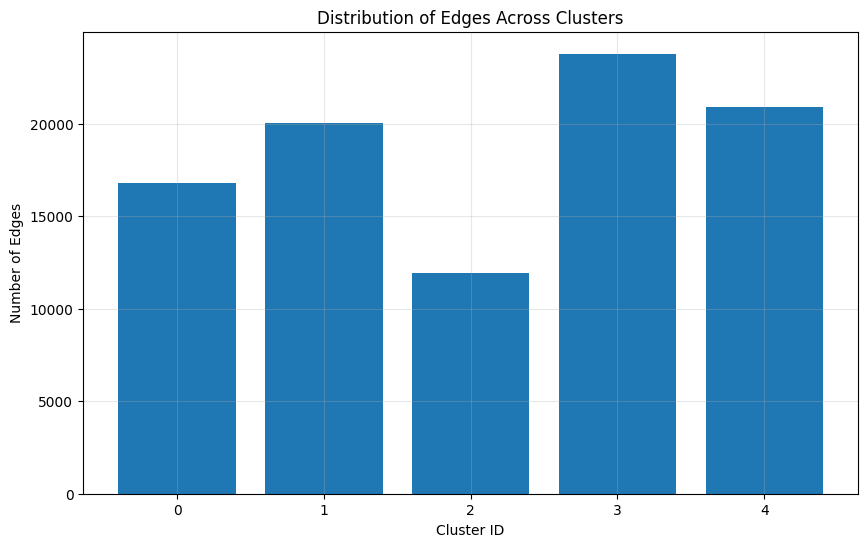

In [ ]:
# Get edge list and analyze cluster distributions
edge_list = list(graph.edges())
cluster_counts = np.bincount(clusters)

# Plot cluster distribution
plt.figure(figsize=(10, 6))
plt.bar(range(len(cluster_counts)), cluster_counts)
plt.title('Distribution of Edges Across Clusters')
plt.xlabel('Cluster ID')
plt.ylabel('Number of Edges')
plt.xticks(range(len(cluster_counts)))
plt.grid(True, alpha=0.3)
plt.show()

## 5. Test Model on New Edges

Let's test the model's ability to predict new edges and reconstruct node attributes:

In [ ]:
# Convert graph to PyTorch Geometric format
edge_list = list(graph.edges())
edge_index = torch.tensor([[u, v] for u, v in edge_list] + [[v, u] for u, v in edge_list], dtype=torch.long).t()

# Convert latent positions to node features
x = torch.tensor(latent, dtype=torch.float)

# Generate test edges
import numpy as np
from relearn.model import sample_negative_edges

test_pos_edges = sample_negative_edges(graph, num_samples=50)
test_neg_edges = sample_negative_edges(graph, num_samples=50)

# Prepare test edge indices
test_edge_index = torch.tensor([[u, v] for u, v in test_pos_edges + test_neg_edges], dtype=torch.long).t()

# Evaluate model
model.eval()
with torch.no_grad():
    # Get node embeddings
    node_embeddings = model.encode(x, edge_index)
    
    # Get edge embeddings for test edges
    z_test, _, _, _, _ = model.encode_edges(node_embeddings, test_edge_index)
    
    # Get predictions
    edge_preds = model.decode_network(z_test)
    attr_recon = model.decode_attributes(z_test)
    
    # Ground truth
    edge_labels = torch.cat([torch.ones(len(test_pos_edges)), torch.zeros(len(test_neg_edges))], dim=0)
    
    # Evaluate edge prediction
    predictions = (edge_preds > 0.5).float()
    accuracy = (predictions == edge_labels).float().mean().item()
    
    print(f"Edge prediction accuracy on test set: {accuracy:.4f}")
    
    # Confusion matrix
    tp = ((predictions == 1) & (edge_labels == 1)).sum().item()
    tn = ((predictions == 0) & (edge_labels == 0)).sum().item()
    fp = ((predictions == 1) & (edge_labels == 0)).sum().item()
    fn = ((predictions == 0) & (edge_labels == 1)).sum().item()
    
    print(f"True Positives: {tp}, True Negatives: {tn}")
    print(f"False Positives: {fp}, False Negatives: {fn}")

Edge prediction accuracy on test set: 0.5000
True Positives: 50, True Negatives: 0
False Positives: 50, False Negatives: 0


## 6. Analyze Mixture Components

Let's examine the learned Gaussian mixture components:

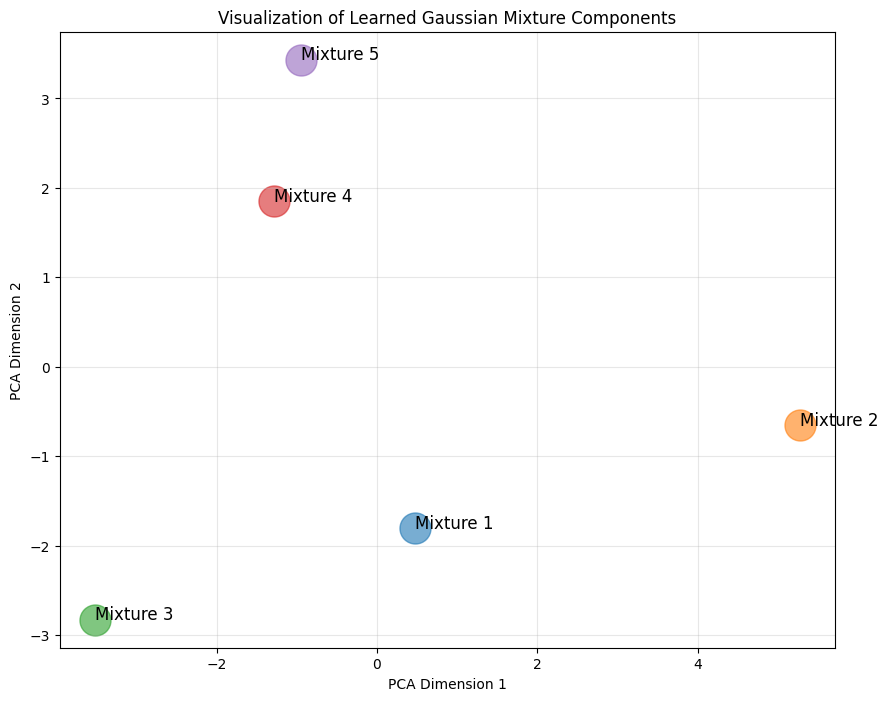

In [ ]:
# Extract learned mixture components
mixture_means = model.edge_encoder.mixture_means.detach().numpy()
mixture_vars = torch.exp(model.edge_encoder.mixture_log_vars).detach().numpy()

# Perform PCA on the mixture means to visualize in 2D
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_means = pca.fit_transform(mixture_means)

# Plot the mixture components
plt.figure(figsize=(10, 8))

# Calculate average variance for sizing the circles
avg_vars = mixture_vars.mean(axis=1)
size_scale = 500  # Scale factor for circle sizes

# Plot each mixture component as a circle
for i in range(len(reduced_means)):
    plt.scatter(reduced_means[i, 0], reduced_means[i, 1], 
                s=avg_vars[i] * size_scale,
                alpha=0.6, label=f'Mixture {i+1}')
    
    # Annotate the component
    plt.annotate(f"Mixture {i+1}", 
                 (reduced_means[i, 0], reduced_means[i, 1]),
                 fontsize=12)

plt.title('Visualization of Learned Gaussian Mixture Components')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Analyzing Edge Embedding Quality

Let's measure how well our edge embeddings capture the topological properties of the graph:

Cluster Statistics:


weight            avg_degree            degree_diff             \
             mean       std        mean        std        mean        std   
cluster                                                                     
0        1.633745  0.338509  389.968379  47.853817   76.938726  64.140775   
1        1.628638  0.336983  390.268426  47.490890   77.442475  64.809932   
2        1.628445  0.345734  388.938932  48.341598   79.175439  66.904264   
3        1.634712  0.343418  392.953074  46.215072   75.476831  62.841552   
4        1.630678  0.339346  391.833421  46.840487   75.002634  62.361794   

        latent_dist             edge  
               mean       std  count  
cluster                               
0          0.633486  0.107203  16777  
1          0.635245  0.106708  20026  
2          0.636036  0.107892  11913  
3          0.633409  0.107518  23782  
4          0.634815  0.107758  20882

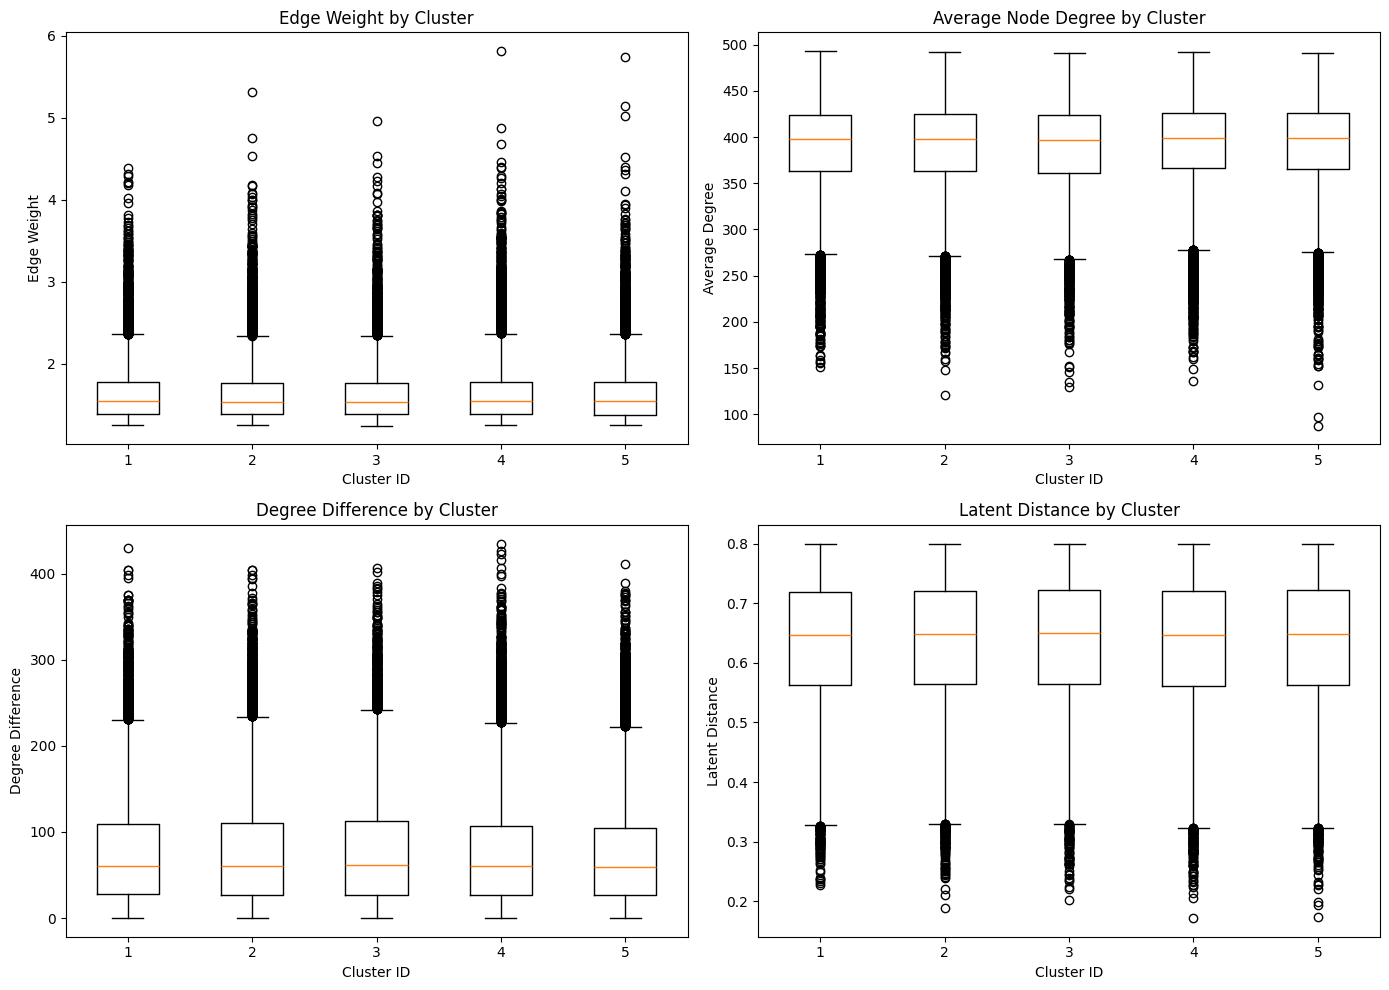

In [ ]:
# Compute edge properties for analysis
edge_properties = []

for u, v in edge_list:
    # Get weight
    weight = graph[u][v].get('weight', 1.0)
    
    # Get node degrees
    degree_u = graph.degree(u)
    degree_v = graph.degree(v)
    
    # Get latent distance
    latent_dist = np.linalg.norm(latent[u] - latent[v])
    
    edge_properties.append({
        'edge': (u, v),
        'weight': weight,
        'avg_degree': (degree_u + degree_v) / 2,
        'degree_diff': abs(degree_u - degree_v),
        'latent_dist': latent_dist,
        'cluster': clusters[edge_list.index((u, v))]
    })

# Convert to DataFrame for easier analysis
import pandas as pd
edge_df = pd.DataFrame(edge_properties)

# Analyze cluster properties
cluster_stats = edge_df.groupby('cluster').agg({
    'weight': ['mean', 'std'],
    'avg_degree': ['mean', 'std'],
    'degree_diff': ['mean', 'std'],
    'latent_dist': ['mean', 'std'],
    'edge': 'count'
})

print("Cluster Statistics:")
display(cluster_stats)

# Visualize relationship between clusters and edge properties
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot weight distribution by cluster
axes[0, 0].boxplot([edge_df[edge_df['cluster'] == c]['weight'] for c in range(len(cluster_counts))])
axes[0, 0].set_title('Edge Weight by Cluster')
axes[0, 0].set_xlabel('Cluster ID')
axes[0, 0].set_ylabel('Edge Weight')

# Plot average degree distribution by cluster
axes[0, 1].boxplot([edge_df[edge_df['cluster'] == c]['avg_degree'] for c in range(len(cluster_counts))])
axes[0, 1].set_title('Average Node Degree by Cluster')
axes[0, 1].set_xlabel('Cluster ID')
axes[0, 1].set_ylabel('Average Degree')

# Plot degree difference distribution by cluster
axes[1, 0].boxplot([edge_df[edge_df['cluster'] == c]['degree_diff'] for c in range(len(cluster_counts))])
axes[1, 0].set_title('Degree Difference by Cluster')
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Degree Difference')

# Plot latent distance distribution by cluster
axes[1, 1].boxplot([edge_df[edge_df['cluster'] == c]['latent_dist'] for c in range(len(cluster_counts))])
axes[1, 1].set_title('Latent Distance by Cluster')
axes[1, 1].set_xlabel('Cluster ID')
axes[1, 1].set_ylabel('Latent Distance')

plt.tight_layout()
plt.show()

## 8. Visualizing Edge Clusters in the Original Graph

Let's visualize how the edge clusters are distributed in the original graph space:

ValueError: 'vertices' must be 2D with shape (N, 2), but your input has shape (2, 10)

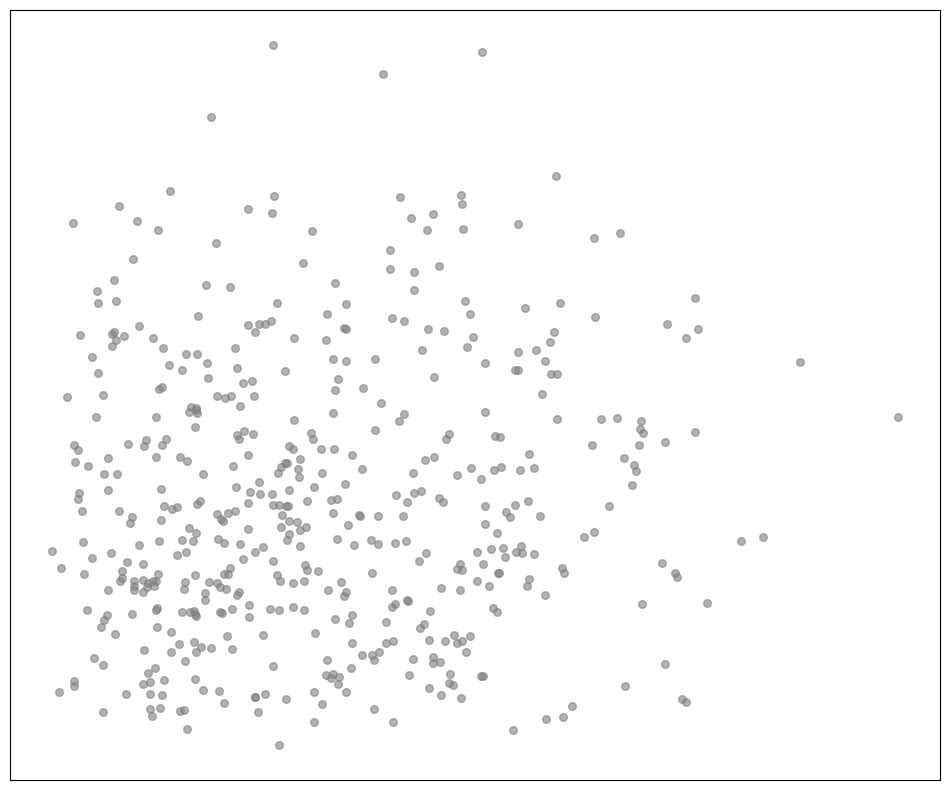

In [ ]:
# Create a plot of the graph with edges colored by cluster
plt.figure(figsize=(12, 10))

# Plot nodes
nx.draw_networkx_nodes(
    graph, 
    pos={i: latent[i] for i in range(len(latent))},
    node_size=30,
    node_color='gray',
    alpha=0.6
)

# Plot edges by cluster
edge_colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown']
for c in range(len(cluster_counts)):
    cluster_edges = [edge for i, edge in enumerate(edge_list) if clusters[i] == c]
    
    if cluster_edges:  # Check if there are edges in this cluster
        nx.draw_networkx_edges(
            graph,
            pos={i: latent[i] for i in range(len(latent))},
            edgelist=cluster_edges,
            width=1.0,
            alpha=0.6,
            edge_color=edge_colors[c % len(edge_colors)],
            label=f'Cluster {c}'
        )

plt.title('Graph with Edges Colored by Learned Clusters')
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()

## 9. Evaluate Attribute Reconstruction

Let's evaluate how well our model reconstructs node attributes:

In [ ]:
# Evaluate attribute reconstruction on test edges
model.eval()
with torch.no_grad():
    # Get node embeddings
    node_embeddings = model.encode(x, edge_index)
    
    # Get edge embeddings for test edges
    test_edges = test_pos_edges[:20]  # Take a few positive test edges
    test_edge_index = torch.tensor([[u, v] for u, v in test_edges], dtype=torch.long).t()
    
    # Get edge embeddings
    z_test, _, _, _, _ = model.encode_edges(node_embeddings, test_edge_index)
    
    # Get attribute reconstructions
    attr_recon = model.decode_attributes(z_test)
    
    # Prepare ground truth
    src_nodes = test_edge_index[0]
    dst_nodes = test_edge_index[1]
    attr_targets = torch.cat([x[src_nodes], x[dst_nodes]], dim=1)
    
    # Compute reconstruction error
    recon_error = F.mse_loss(attr_recon, attr_targets, reduction='none').mean(dim=1)
    
    # Display original vs. reconstructed attributes for a few examples
    print("Node Attribute Reconstruction Example:")
    for i in range(min(5, len(test_edges))):
        u, v = test_edges[i]
        print(f"\nEdge ({u}, {v}):")
        print(f"Original node features (u): {latent[u]}")
        print(f"Original node features (v): {latent[v]}")
        print(f"Reconstructed features: {attr_recon[i].numpy()}")
        print(f"Reconstruction error: {recon_error[i].item():.4f}")
        
    # Plot histogram of reconstruction errors
    plt.figure(figsize=(10, 6))
    plt.hist(recon_error.numpy(), bins=20)
    plt.title('Distribution of Attribute Reconstruction Errors')
    plt.xlabel('MSE Error')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.show()

NameError: name 'F' is not defined

## 10. Conclusion and Insights

This implementation demonstrates a simplified version of the ReLearn model with:

1. **Gaussian Mixture VAE** for learning meaningful edge embeddings
2. **Two decoders**: network proximity and node attributes
3. **No information diffusion decoder** (omitted from the original model)

The visualizations and analysis show how the model:
- Learns to cluster edges into meaningful groups based on topological properties
- Can predict link existence with reasonable accuracy
- Reconstructs node attributes from edge embeddings

Key insights:
- The mixture components capture different types of edge relationships
- Edge clusters often correspond to different structural patterns in the graph
- The model effectively learns from both network structure and node attributes